#### Prepare the program

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style = 'darkgrid',
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

#### Define the training set and output

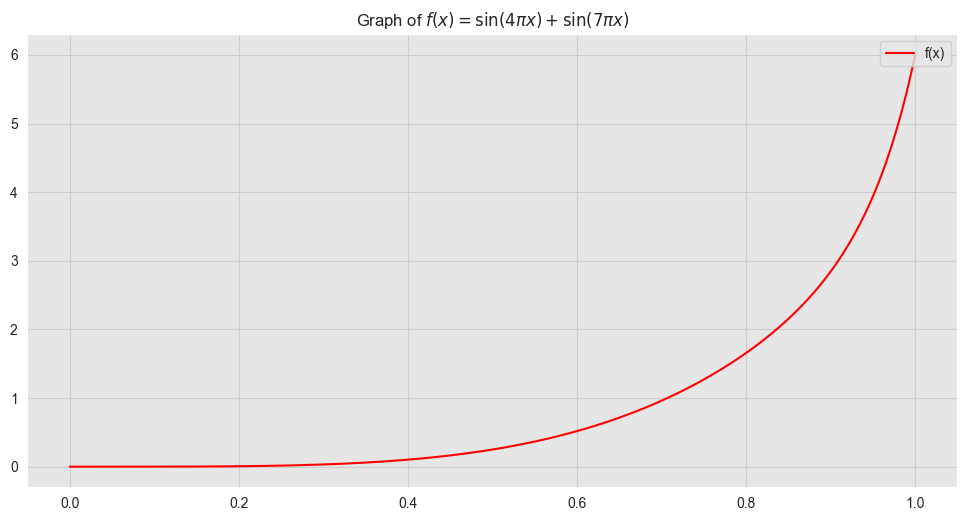

In [75]:
#Define dimension
d = 1
# Define number of samples (training set)
n = 500

x = np.linspace(start = 0, stop = 1, num = n)

def getY(x):
#     y = np.sin((4 * np.pi) * x) + np.sin((7 * np.pi)*x)
    y = 2 * x ** 21 + 4 * x ** 4
    return y

f_x = getY(x)

fig, ax = plt.subplots()
#Plot the function 
sns.lineplot(x=x, y=f_x, color='red', label='f(x)', ax=ax)
# Plot function components
# sns.lineplot(x=x, y=np.sin((4*np.pi)*x), color='orange', label='$\sin(4 \pi x)$', alpha=0.3, ax=ax)
# sns.lineplot(x=x, y=np.sin((7*np.pi)*x), color='purple', label='$\sin(7 \pi x)$', alpha=0.3, ax=ax)
ax.legend(loc='upper right')
ax.set_title(r'Graph of $f(x) = \sin(4\pi x) + \sin(7\pi x)$');

In [77]:
y.shape

(500,)

#### Define the Error Function

In [43]:
# Mean and variance for the Gaussian Noise
sigma_n = 0.4
e = np.random.normal(loc=0, scale=sigma_n, size=n)
y = f_x + e

C:\Users\jirui\.conda\envs\torch\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Error distribution')]

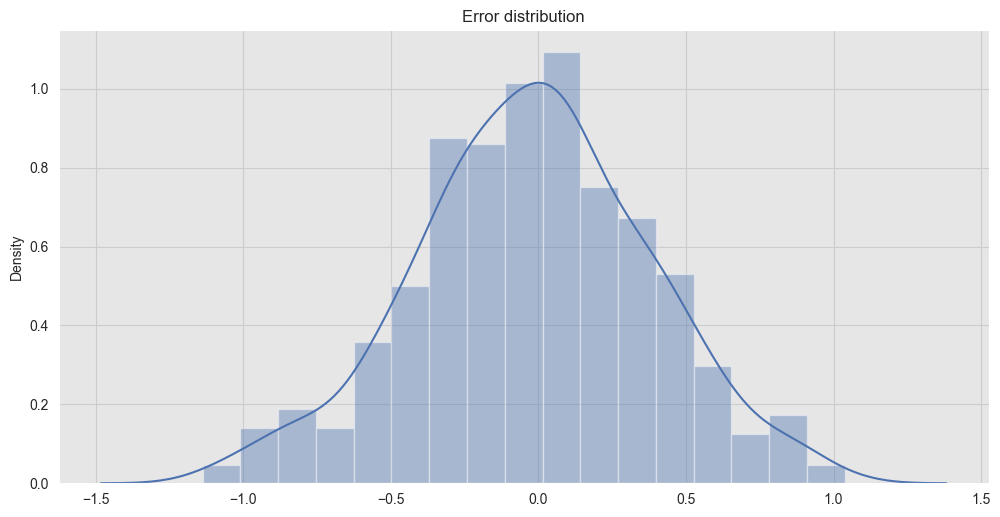

In [44]:
fig, ax = plt.subplots()
# Visualize the Gaussian Noise
sns.distplot(e, ax=ax)
ax.set(title = 'Error distribution')

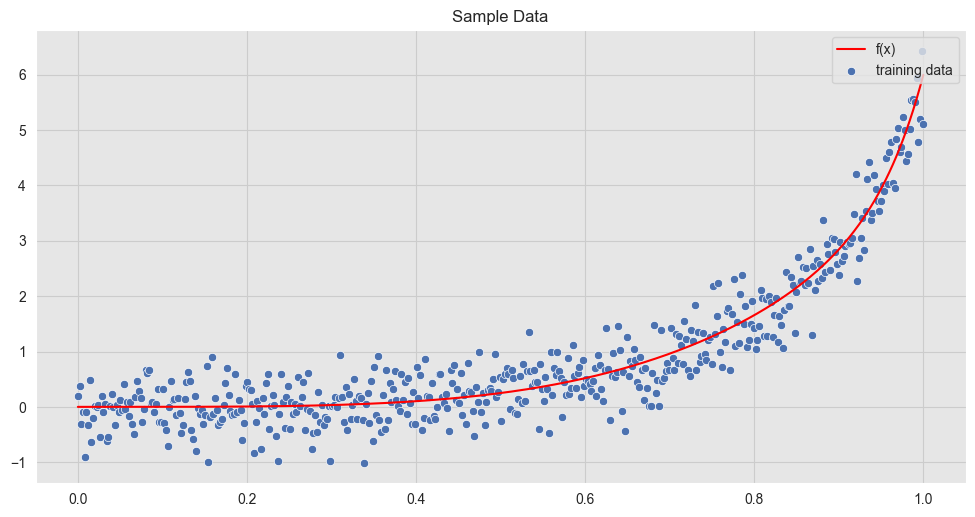

In [45]:
# Visualize the sampling data:
fig, ax = plt.subplots()
# Plot training data.
sns.scatterplot(x=x, y=y, label='training data', ax=ax);
# Plot "true" linear fit.
sns.lineplot(x=x, y=f_x, color='red', label='f(x)', ax=ax);

ax.set(title='Sample Data')
ax.legend(loc='upper right');


In [46]:
n_star = 100
x_star = np.linspace(start = 0, stop = 1, num=n_star)


In [47]:
def kernel_function(x, y, sigma_f=1, l=1):
    """Define squared exponential kernel function."""
    kernel = sigma_f * np.exp(- (np.linalg.norm(x - y)**2) / (2 * l**2))
    return kernel

In [48]:
l = 0.1
sigma_f = 2

In [49]:
import itertools

def compute_cov_matrices(x, x_star, sigma_f=1, l=1):
    """
    Compute components of the covariance matrix of the joint distribution.
    
    We follow the notation:
    
        - K = K(X, X) 
        - K_star = K(X_*, X)
        - K_star2 = K(X_*, X_*)
    """
    n = x.shape[0]
    n_star = x_star.shape[0]

    K = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x, x)]

    K = np.array(K).reshape(n, n)
    
    K_star2 = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x_star, x_star)]

    K_star2 = np.array(K_star2).reshape(n_star, n_star)
    
    K_star = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x_star, x)]

    K_star = np.array(K_star).reshape(n_star, n)
    
    return (K, K_star2, K_star)

In [50]:
K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l)

In [51]:
K.shape

(500, 500)

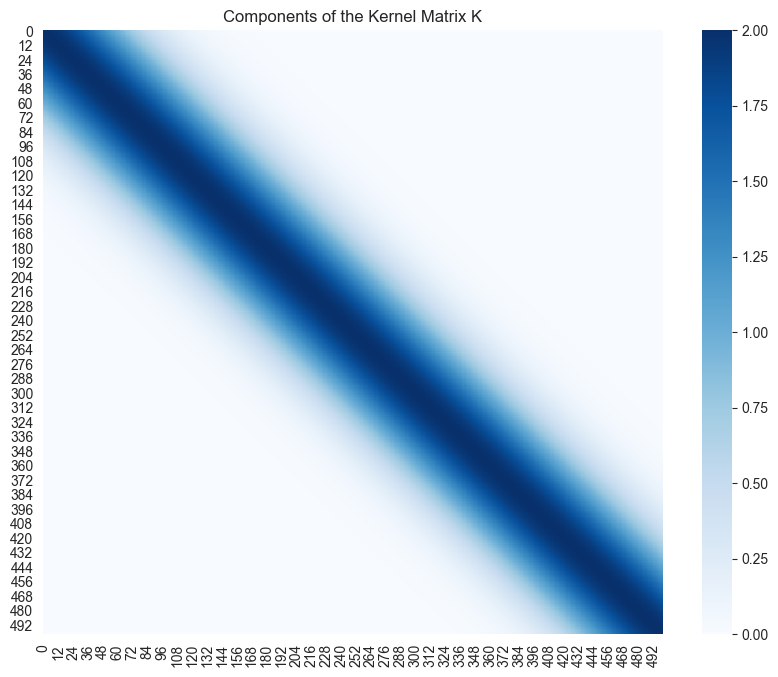

In [52]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=K, cmap='Blues', ax=ax)
ax.set(title='Components of the Kernel Matrix K');

In [53]:
K_star2.shape

(100, 100)

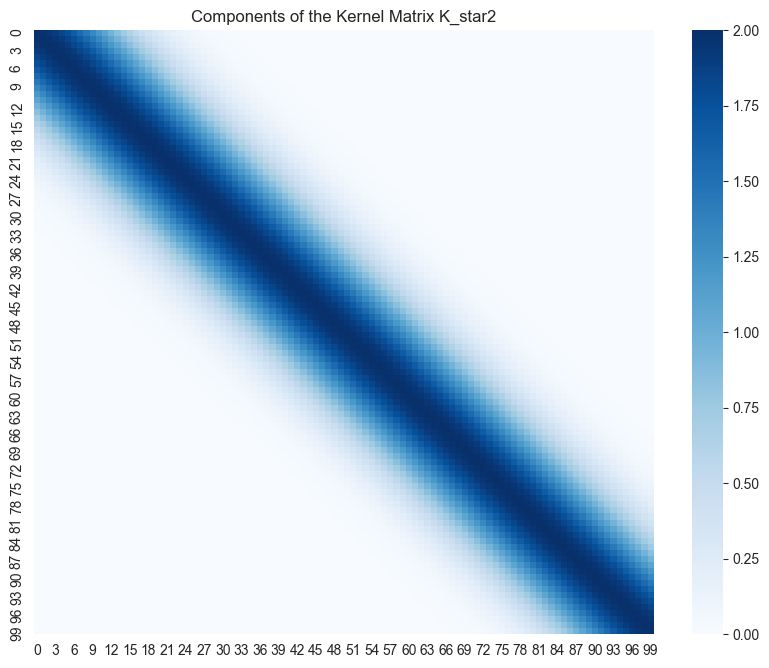

In [54]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=K_star2, cmap='Blues', ax=ax)
ax.set(title='Components of the Kernel Matrix K_star2');

In [55]:
K_star.shape

(100, 500)

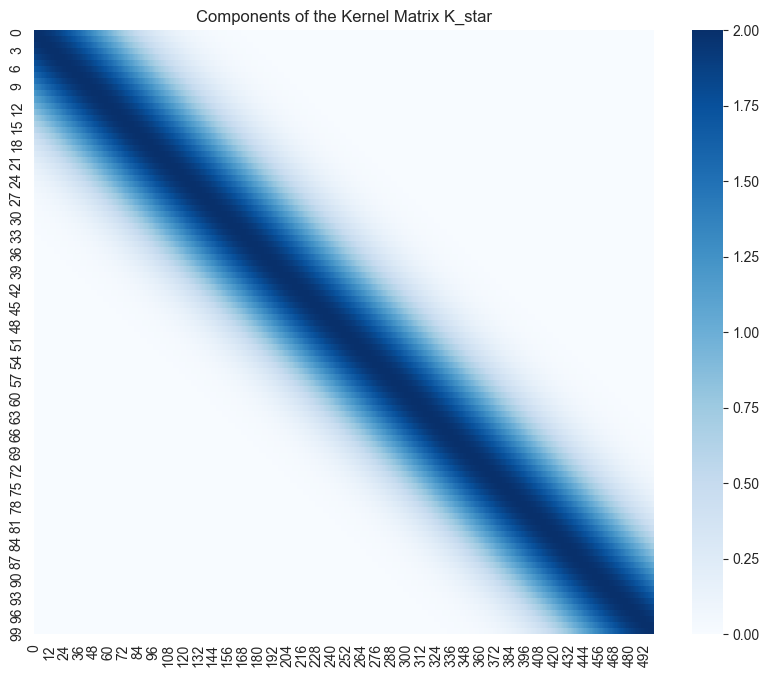

In [56]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=K_star, cmap='Blues', ax=ax)
ax.set(title='Components of the Kernel Matrix K_star');

In [57]:
a = np.concatenate((K + (sigma_n**2)*np.eye(n), K_star), axis=0)
a.shape

(600, 500)

In [58]:
b = np.concatenate((K_star.T, K_star2), axis=0)
b.shape

(600, 100)

In [59]:
C = np.concatenate((a, b), axis=1)
C.shape

(600, 600)

In [60]:
C.shape == (n + n_star, n + n_star)

True

In [61]:
np.all(C.T == C)

True

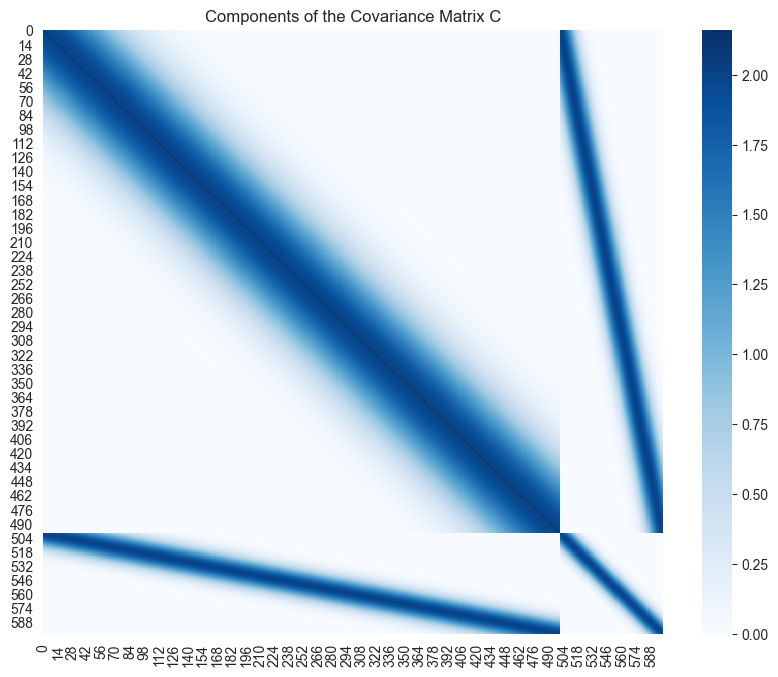

In [62]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=C, cmap='Blues', ax=ax)
ax.set(title='Components of the Covariance Matrix C');

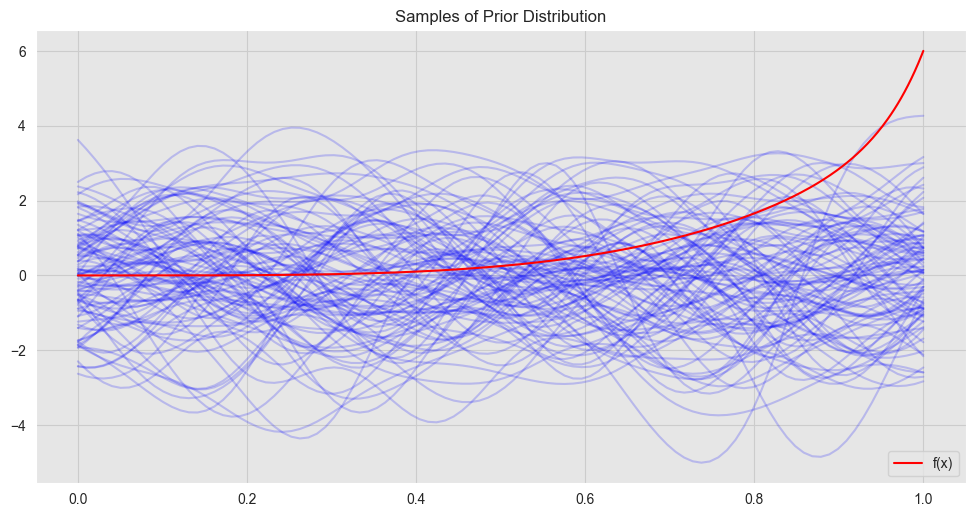

In [63]:
fig, ax = plt.subplots()

for i in range(0, 100):
    # Sample from prior distribution. 
    z_star = np.random.multivariate_normal(mean=np.zeros(n_star), cov=K_star2)
    # Plot function.
    sns.lineplot(x=x_star, y=z_star, color='blue', alpha=0.2, ax=ax)
    
# Plot "true" linear fit.
sns.lineplot(x=x, y=f_x, color='red', label='f(x)', ax=ax)
ax.set(title='Samples of Prior Distribution')
ax.legend(loc='lower right');

In [64]:
def compute_gpr_parameters(K, K_star2, K_star, sigma_n):
    """Compute gaussian regression parameters."""
    n = K.shape[0]
    # Mean.
    f_bar_star = np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), y.reshape([n, d])))
    # Covariance.
    cov_f_star = K_star2 - np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), K_star.T))
    
    return (f_bar_star, cov_f_star)

In [65]:
# Compute posterior mean and covariance. 
f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star, sigma_n)

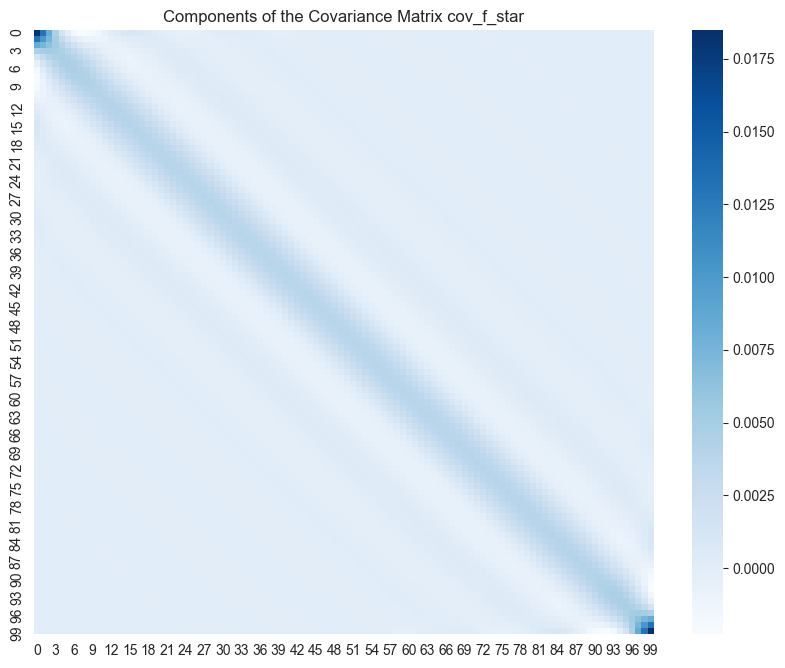

In [66]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=cov_f_star, cmap='Blues', ax=ax)
ax.set_title('Components of the Covariance Matrix cov_f_star');

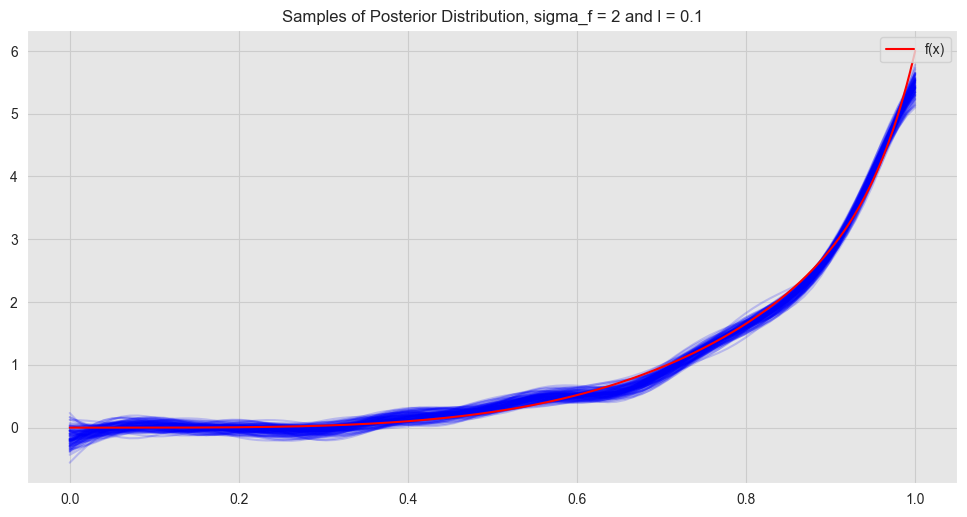

In [67]:
fig, ax = plt.subplots()

for i in range(0, 100):
    # Sample from posterior distribution. 
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    # Plot function.
    sns.lineplot(x=x_star, y=z_star, color="blue", alpha=0.2, ax=ax);
    
# Plot "true" linear fit.
sns.lineplot(x=x, y=f_x, color='red', label = 'f(x)', ax=ax)
ax.set(title=f'Samples of Posterior Distribution, sigma_f = {sigma_f} and l = {l}')
ax.legend(loc='upper right');

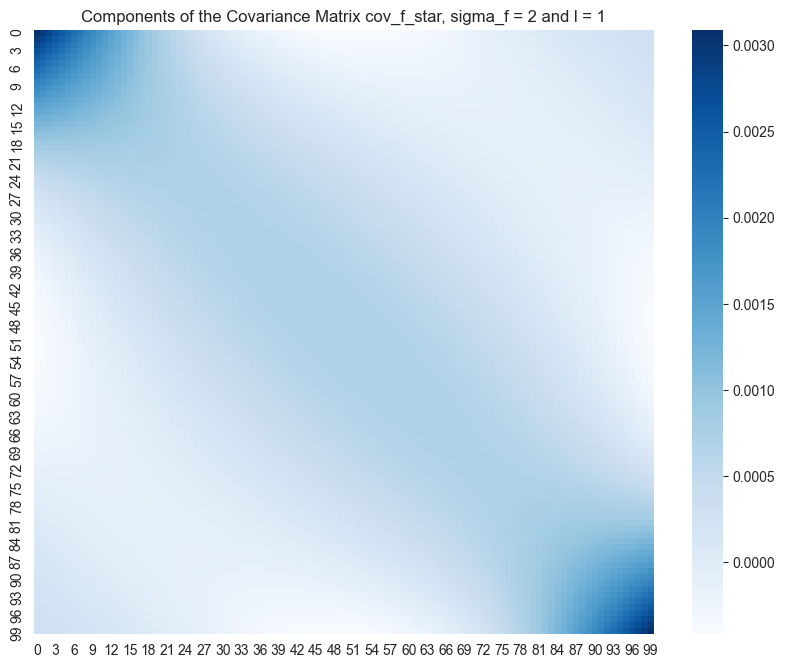

In [68]:
l = 1
sigma_f = 2

# Compute covariance matrices. 
K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l)
# Compute gaussian process parameters. 
f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star, sigma_n)

# Plot posterior covariance matrix components. 
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=cov_f_star, cmap='Blues', ax=ax)
ax.set(title=f'Components of the Covariance Matrix cov_f_star, sigma_f = {sigma_f} and l = {l}');

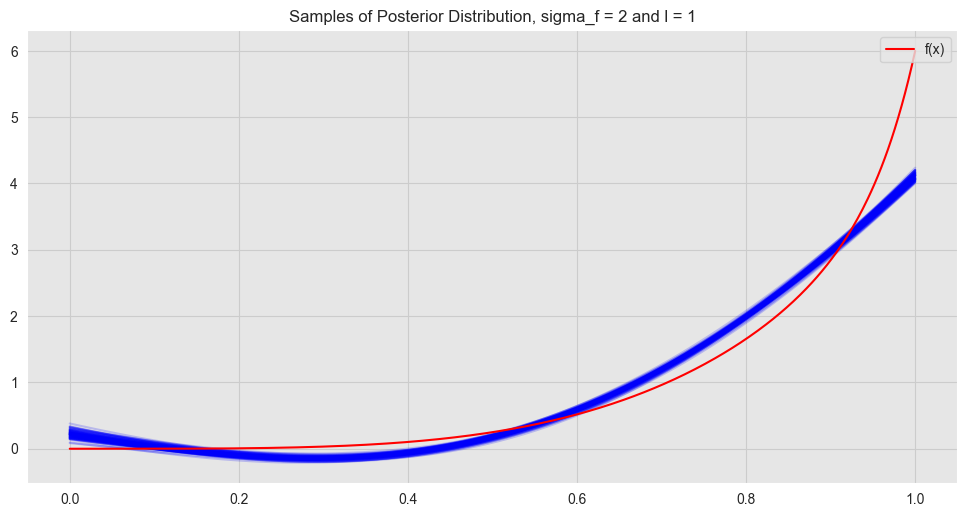

In [69]:
K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f=sigma_f, l=l)

f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star, sigma_n)

fig, ax = plt.subplots()

for i in range(0, 100):
    # Sample from posterior distribution. 
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    # Plot function.
    sns.lineplot(x=x_star, y=z_star, color='blue', alpha=0.2, ax=ax);
    
# Plot "true" linear fit.
sns.lineplot(x=x, y=f_x, color='red', label='f(x)', ax=ax)
ax.set(title=f'Samples of Posterior Distribution, sigma_f = {sigma_f} and l = {l}')
ax.legend(loc='upper right');

### GaussianProcessRegressor from Scikit-Learn
Note that in the examples above he had to compute the inverse of 
K
(
X
,
X
)
+
σ
2
n
I
, which can be computationally expensive for larger data sets. A better approach is to use the Cholesky decomposition of 
K
(
X
,
X
)
+
σ
2
n
I
 as described in Gaussian Processes for Machine Learning, Ch 2 Algorithm 2.1. This is actually the implementation used by Scikit-Learn. We now describe how to fit a GaussianProcessRegressor model using Scikit-Learn and compare it with the results obtained above. Please refer to the docomentation example to get more detailed information.

### Kernel Object
There are my kernel functions implemented in Scikit-Learn. Let us see how define the squared exponential:

In [70]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

# Define kernel parameters. 
l = 0.1
sigma_f = 2

# Define kernel object. 
kernel = ConstantKernel(constant_value=sigma_f,constant_value_bounds=(1e-3, 1e3)) \
            * RBF(length_scale=l, length_scale_bounds=(1e-3, 1e3))

The tuples on each kernel component represent the lower and upper bound of the hyperparameters. The gaussian process fit automatically selects the best hyperparameters which maximize the log-marginal likelihood. The marginal likelihood is the integral of the likelihood times the prior.

### GaussianProcessRegressor
Now we define de GaussianProcessRegressor object.

In [71]:
from sklearn.gaussian_process import GaussianProcessRegressor
# Define GaussianProcessRegressor object. 
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=10)

We reshape the variables into matrix form.

In [72]:
X = x.reshape(n, d)
X_star = x_star.reshape(n_star, d)
# Fit to data using Maximum Likelihood Estimation of the parameters.
gp.fit(X, y)

C:\Users\jirui\.conda\envs\torch\lib\site-packages\sklearn\gaussian_process\_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(alpha=0.16000000000000003,
                         kernel=1.41**2 * RBF(length_scale=0.1),
                         n_restarts_optimizer=10)

### Prediction

In [73]:
# Make the prediction on test set.
y_pred = gp.predict(X_star)

Let us plot the prediction.

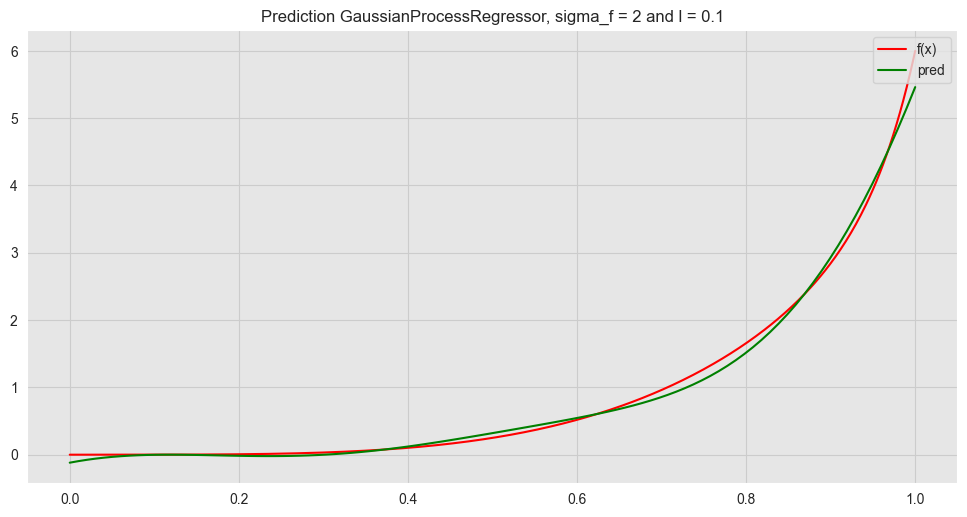

In [74]:
fig, ax = plt.subplots()
# Plot "true" linear fit.
sns.lineplot(x=x, y=f_x, color='red', label='f(x)', ax=ax)
# Plot prediction. 
sns.lineplot(x=x_star, y=y_pred, color='green', label='pred', ax=ax)
ax.set(title=f'Prediction GaussianProcessRegressor, sigma_f = {sigma_f} and l = {l}')
ax.legend(loc='upper right');                                                         

### Summary & Final Example
In this post we have studied and experimented the fundamentals of gaussian process regression with the intention to gain some intuition about it. Let us finalize with a self-contain example where we only use the tools from Scikit-Learn.
### Construct Training Set

In [39]:
# Set dimension. 
d = 1
# Number of training points.
n = 1000
# Length of the training set. 
L = 2
# Generate training features.
x = np.linspace(start=0, stop=L, num=n)
X = x.reshape(n, d)
# Error standar deviation. 
sigma_n = 0.4
# Errors.
epsilon = np.random.normal(loc=0, scale=sigma_n, size=n)

# Generate non-linear function.
def f(x):
    f = np.sin((4*np.pi)*x) + np.sin((7*np.pi)*x) + np.sin((3*np.pi)*x) 
    return(f)

f_x = f(x)

# Observed target variable. 
y = f_x + epsilon

### Construct Test Set

In [40]:
n_star = n + 300
x_star = np.linspace(start=0, stop=(L + 0.5), num=n_star)

X_star = x_star.reshape(n_star, d)

### Define Kernel and Model

In [41]:
# Define kernel parameters. 
l = 0.1
sigma_f = 2

# Define kernel object. 
kernel = ConstantKernel(constant_value=sigma_f, constant_value_bounds=(1e-2, 1e2)) \
            * RBF(length_scale=l, length_scale_bounds=(1e-2, 1e2))
# Define GaussianProcessRegressor object. 
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=10, )

### Model fit and Prediction

In [42]:
# Fit to data using Maximum Likelihood Estimation of the parameters.
gp.fit(X, y)
# Make the prediction on test set.
y_pred = gp.predict(X_star)
# Generate samples from posterior distribution. 
y_hat_samples = gp.sample_y(X_star, n_samples=n_star)
# Compute the mean of the sample. 
y_hat = np.apply_over_axes(func=np.mean, a=y_hat_samples, axes=1).squeeze()
# Compute the standard deviation of the sample. 
y_hat_sd = np.apply_over_axes(func=np.std, a=y_hat_samples, axes=1).squeeze()

### Visualize the Results

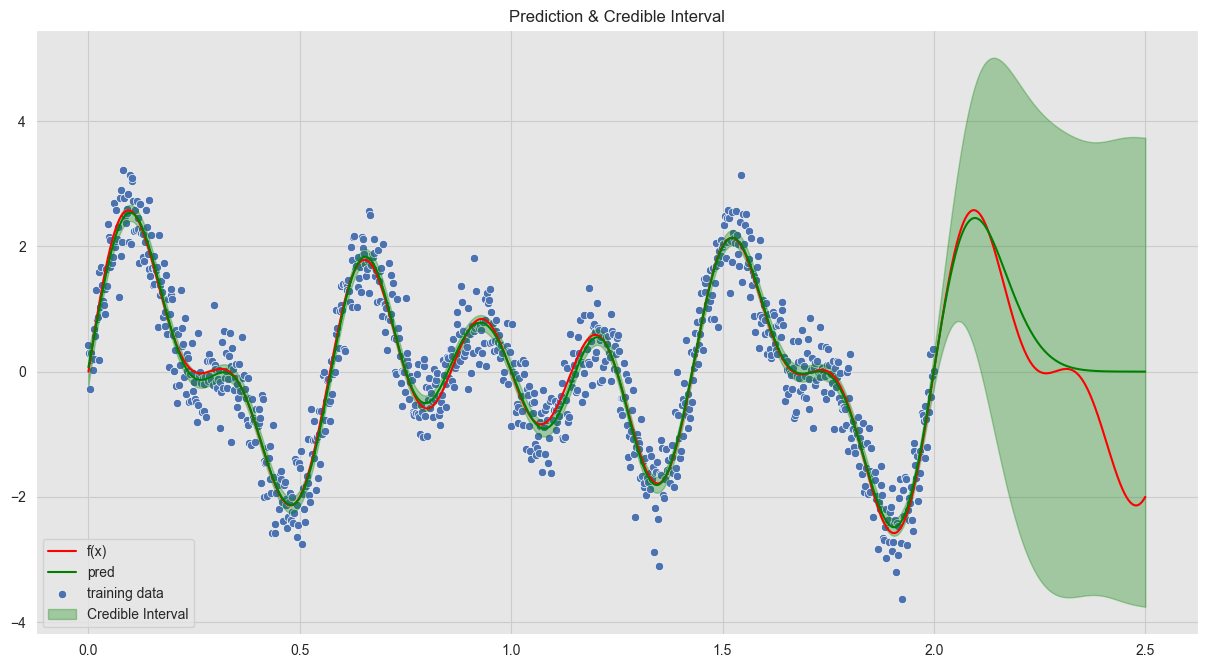

In [43]:
fig, ax = plt.subplots(figsize=(15, 8))
# Plot training data.
sns.scatterplot(x=x, y=y, label='training data', ax=ax);
# Plot "true" linear fit.
sns.lineplot(
    x=x_star, 
    y=f(x_star), 
    color='red', 
    label='f(x)', 
    ax=ax
)
# Plot corridor. 
ax.fill_between(
    x=x_star, 
    y1=(y_hat - 2*y_hat_sd), 
    y2=(y_hat + 2*y_hat_sd), 
    color='green',
    alpha=0.3, 
    label='Credible Interval'
)
# Plot prediction. 
sns.lineplot(x=x_star, y=y_pred, color='green', label='pred')
ax.set(title='Prediction & Credible Interval')
ax.legend(loc='lower left');